In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append('../../..')
from src import bounded_mean_1d
from matplotlib.font_manager import FontProperties
%matplotlib widget

if not os.path.exists('Figs'):
    os.mkdir('Figs')

In [2]:
df = pd.read_csv('../../Raw analysis/PAR-2 NEBD quantification/NEBD_Embryos_dataframe.csv')
df_quantification = pd.read_csv('../../Raw analysis/PAR-2 NEBD quantification/QUANTIFICATION.csv')
df_quantification_grouped = df_quantification.groupby('EmbryoID')

df_summary = pd.DataFrame()
for i, r in df_quantification_grouped:
    cyt = np.mean(r['Cytoplasmic signal'])
    mem_tot = np.mean(r['Membrane signal'])
    mem_ant = bounded_mean_1d(r['Membrane signal'], [0.4, 0.6])
    mem_post = bounded_mean_1d(r['Membrane signal'], [0.9, 0.1]) 
    mem_frac = mem_tot / ((cyt / 0.174) + mem_tot)
    ratio_post = mem_post / cyt
    dosage = cyt + (mem_tot * 0.174)
    p = {'EmbryoID': i, 'Cyt': cyt, 'Mem_tot': mem_tot, 'Mem_ant': mem_ant, 'Mem_post': mem_post,
        'Ratio post': ratio_post, 'Mem frac': mem_frac, 'Dosage': dosage} 
    df_summary = df_summary.append(pd.DataFrame(p, index=[i]))
df = pd.merge(df, df_summary, on='EmbryoID')

# Filter
df = df[df.Line.isin(['lp637', 'nwg201', 'nwg240', 'nwg246', 'nwg338', 'nwg369'])]
df = df[df.RNAi == 'wt']

# Add uniform vs polarised column
unipol = ['Pol' if x in ['lp637', 'nwg240', 'nwg338'] else 'Uni' for x in df.Line]
df['UniPol'] = unipol

# Add genotype column
genotype = ['WT' if x in ['lp637', 'nwg201'] else 'C56S' if x in ['nwg240', 'nwg246'] else 'L109R' for x in df.Line]
df['Genotype'] = genotype

# Normalise
norm = df[df.Line == 'lp637'].Cyt.mean()
df.Cyt /= norm
df.Mem_tot /= norm
df.Mem_ant /= norm
df.Mem_post /= norm
df.Dosage /= norm

In [3]:
df1 = df[df.UniPol == 'Pol']
df2 = df[df.UniPol == 'Uni']

In [4]:
def create_table(df):
    means = df.groupby('Genotype').mean()[['Cyt', 'Mem_post', 'Ratio post', 'Mem frac']]
    means = means.rename(columns={'Cyt': 'Cyt_mean', 'Mem_post': 'Mem_mean', 'Ratio post': 'Ratio_mean',
                                 'Mem frac': 'Memfrac_mean'})
    stds = df.groupby('Genotype').std()[['Cyt', 'Mem_post', 'Ratio post', 'Mem frac']]
    stds = stds.rename(columns={'Cyt': 'Cyt_std', 'Mem_post': 'Mem_std', 'Ratio post': 'Ratio_std',
                               'Mem frac': 'Memfrac_std'})
    a = pd.concat([means, stds], axis=1)
    
    c1 = a.apply(lambda x: f'{x["Cyt_mean"]:.2f} ± {x["Cyt_std"]:.2f}', axis=1)
    c2 = a.apply(lambda x: f'{x["Mem_mean"]:.2f} ± {x["Mem_std"]:.2f}', axis=1)
    c3 = a.apply(lambda x: f'{x["Ratio_mean"]:.2f} ± {x["Ratio_std"]:.2f}', axis=1)
    c4 = a.apply(lambda x: f'{x["Memfrac_mean"]:.2f} ± {x["Memfrac_std"]:.2f}', axis=1)

    RESULTS = pd.DataFrame({'Normalised cytoplasmic\nconcentration (μm⁻³)': c1, 
                            'Normalised membrane\nconcentration (μm⁻²)': c2, 
                            'M:C ratio (μm)': c3,
                            'Fraction at\nmembrane': c4})
    RESULTS = RESULTS.reindex(["WT", "C56S", "L109R"])
    RESULTS.insert(loc=0, column='Genotype', value=RESULTS.index)
    return RESULTS

def plot_table(results):
    fig, ax = plt.subplots()

    cell_text = []
    for row in range(len(results)):
        cell_text.append(results.iloc[row])

    widths = np.array([0.1, 0.22, 0.22, 0.15, 0.22])
    tab = ax.table(cellText=cell_text, colLabels=results.columns, loc='center', colWidths=widths,
                  cellLoc='left', colLoc='left')
    tab.auto_set_font_size(False)
    cellDict = tab.get_celld()
    for i in range(0,len(results.columns)):
        cellDict[(0,i)].set_height(.1)
        for j in range(1,len(cell_text)+1):
            cellDict[(j,i)].set_height(.05)
    ax.axis('off')
    fig.set_size_inches(9,5)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
#     fig.tight_layout()

### Individual tables

In [5]:
RESULTS1 = create_table(df1)
# plot_table(RESULTS1)

In [6]:
RESULTS2 = create_table(df2)
# plot_table(RESULTS2)

### Full table

In [7]:
def create_table2(df):
    means = df.groupby('Genotype').mean()[['Cyt', 'Mem_post', 'Ratio post', 'Mem frac', 'Dosage']]
    means = means.rename(columns={'Cyt': 'Cyt_mean', 'Mem_post': 'Mem_mean', 'Ratio post': 'Ratio_mean',
                                 'Mem frac': 'Memfrac_mean', 'Dosage': 'Dosage_mean'})
    stds = df.groupby('Genotype').std()[['Cyt', 'Mem_post', 'Ratio post', 'Mem frac', 'Dosage']]
    stds = stds.rename(columns={'Cyt': 'Cyt_std', 'Mem_post': 'Mem_std', 'Ratio post': 'Ratio_std',
                               'Mem frac': 'Memfrac_std', 'Dosage': 'Dosage_std'})
    a = pd.concat([means, stds], axis=1)
    
    c1 = a.apply(lambda x: f'{x["Cyt_mean"]:.2f} ± {x["Cyt_std"]:.2f}', axis=1)
    c2 = a.apply(lambda x: f'{x["Mem_mean"]:.2f} ± {x["Mem_std"]:.2f}', axis=1)
    c3 = a.apply(lambda x: f'{x["Ratio_mean"]:.2f} ± {x["Ratio_std"]:.2f}', axis=1)
    c4 = a.apply(lambda x: f'{x["Memfrac_mean"]:.2f} ± {x["Memfrac_std"]:.2f}', axis=1)
    c5 = a.apply(lambda x: f'{x["Dosage_mean"]:.2f} ± {x["Dosage_std"]:.2f}', axis=1)

    RESULTS = pd.DataFrame({'Normalised cytoplasmic\nconcentration (μm⁻³)': c1, 
                            'Normalised posterior membrane\nconcentration (μm⁻²)': c2, 
                            'Posterior M:C ratio (μm)': c3,
                            'Fraction at\nmembrane': c4,
                            'Total expression\n(μm⁻³)': c5})
    RESULTS = RESULTS.reindex(["WT", "C56S", "L109R"])
    RESULTS.insert(loc=0, column='Genotype', value=RESULTS.index)
    return RESULTS

In [8]:
RESULTS1b = create_table2(df1)
RESULTS2b = create_table2(df2)
RESULTS1b['Genotype'] = ['PAR-2(WT)', 'PAR-2(C56S)', 'PAR-2(L109R)']
RESULTS2b['Genotype'] = ['PAR-2(WT); par-3(it71)', 'PAR-2(C56S); par-3(it71)', 'PAR-2(L109R); par-3(it71)']
RESULTS_FULLb = pd.concat([RESULTS1b, RESULTS2b], axis=0)

In [9]:
def plot_table2(results):
    fig, ax = plt.subplots()
    fontsize = 7
    cell_text = []
    for row in range(len(results)):
        cell_text.append(results.iloc[row])

    widths = np.array([0.2, 0.2, 0.28, 0.2, 0.13, 0.15])
    tab = ax.table(cellText=cell_text, colLabels=results.columns, loc='center', colWidths=widths/sum(widths),
                  cellLoc='left', colLoc='left')
    tab.auto_set_font_size(False)
    cellDict = tab.get_celld()
    for i in range(0,len(results.columns)):
        cellDict[(0,i)].set_height(.2)
        cellDict[(0,i)].set_text_props(fontproperties=FontProperties(weight='bold'))
        for j in range(1,len(cell_text)+1):
            cellDict[(j,i)].set_height(.1)
    tab.set_fontsize(fontsize)
    ax.axis('off')
    fig.set_size_inches(9,2)
    fig.subplots_adjust(left=0.01, right=0.98, bottom=0, top=1)
    return fig

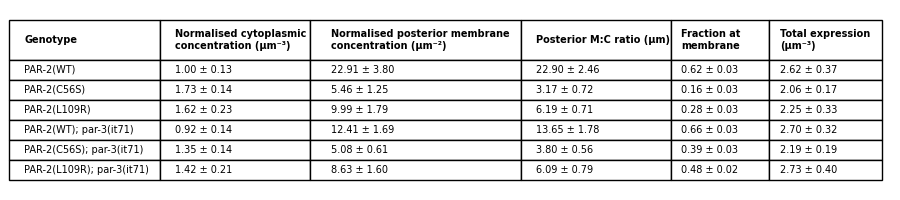

In [10]:
fig = plot_table2(RESULTS_FULLb)
fig.savefig('Figs/results_table.png', dpi=600, transparent=True)